In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# <span style="color:red">ch5_LSTM(RNN,GRU)으로 영화평 구분하기</span>


- imdb사이트의 5만개 영화평 : Train/test - 타겟변수 :  부정/긍정

# 1. 패키지 import


In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스 time을 계산하기 위해서

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score,  precision_score, f1_score

import pandas as pd


# 2. 하이퍼파라미터 설정

- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이남


In [3]:
MY_WORDS = 10000 # imdb 데이터 안의 단어 수
MY_LENGTH =  80  # 독립변수 차원(영화평 단어수 80개로 맞출 예정)
MY_EMBED = 32    # Embadding 결과 차원
MY_HIDDEN = 64   # LSTM의 유닛수

MY_EPOCH = 10    # fit 반복 학습수
MY_BATCH = 200   # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 3. 데이터 불러오기

In [4]:
(X_train,y_train),(X_test,y_test) = imdb.load_data(num_words=MY_WORDS)

In [5]:
print('학습용 독립변수 : ', X_train.shape)
print('학습용 타겟변수 : ',y_train.shape)
print('학습용 독립변수 샘플 : ',type(X_train), X_train[0])
print('학습용 타겟변수(0: 부정/1:긍정) 샘플 : ', y_train[0])
print('데스트용 독립변수 : ', X_test.shape)
print('테스트용 타겟변수 : ',y_test.shape)

학습용 독립변수 :  (25000,)
학습용 타겟변수 :  (25000,)
학습용 독립변수 샘플 :  <class 'numpy.ndarray'> [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16

In [6]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [7]:
# 긍정갯수
print('학습데이터의 긍정 갯수 :',y_train.sum())
print('테스트데이터의 긍정 갯수 :',y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [8]:
word_to_id  = imdb.get_word_index() # 단어(word), 정수(id)  : word_index 빈도가 높은 단어는 앞으로.
# print(len(word_to_id))
# print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id.get('the'))
# 장수 -> 문자
id_to_word = {} # 정수(id),:문자단어(word)
for key , value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word[1])

19
1
movie
film
the


In [9]:
msg = "What a wonderful movie sdfgb "
msg = msg.lower().split()
print(msg)
# 1 : 리뷰의 시작을 알리는 숫자, 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3 :padding 처리
data = [1]+[word_to_id.get(m,-1)+3 for m in msg]
print('원 후기 내용 : ', msg)
print('encoding된 내용 (data) : ', data)
print('data 추정 : ', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movie', 'sdfgb']
원 후기 내용 :  ['what', 'a', 'wonderful', 'movie', 'sdfgb']
encoding된 내용 (data) :  [1, 51, 6, 389, 20, 2]
data 추정 :  ??? what a wonderful movie ???


In [10]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', 'a', 'wonderful', 'movie', '???']

# 5 . 숫자 영화평 -> 자연어 영화평 함수

In [11]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num-3,'???')
        decoded.append(word)
    print(' '.join(decoded))

In [12]:
decoding(X_train[0]),y_train[0]

??? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ??? is an amazing actor and now the same being director ??? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ??? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ??? to the two little boy's that played the ??? of norman and paul they were just brilliant children are often left out of the ??? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done

(None, 1)

# 6. 영화평 학습용 데이터 처음 10개 길이 출력 함수

In [13]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 : {len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [14]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [15]:
# X_train 후기 중  가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]),min([len(x) for x in X_train])

(2494, 11)

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)
- post 짜르기, post 붙이기 :test의 데이터 정확도 : 0.49531999230384827
-  pre 짜르기, pre 붙이기 :  test의 데이터 정확도 : 0.495959997177124

In [16]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       #truncating='post', # 80 단어 이상일 경우 어디를 짜를 지 여부
                       truncating='pre',
                       #padding='post',
                       padding='pre',    # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                       )
X_test = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       #truncating='post', # 80 단어 이상일 경우 어디를 짜를 지 여부
                       truncating='pre',
                       #padding='post',
                       padding='pre',    # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                       )

show_length()

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


# 8. 최종 데이터 shape확인

In [17]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

In [18]:
#X_train[0]
decoding(X_train[0])

that played the ??? of norman and paul they were just brilliant children are often left out of the ??? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all


# 9. 모델 생성 및 구현

In [19]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,   # 10000
                  output_dim=MY_EMBED,   # 32
                  input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
              input_shape=(MY_LENGTH,MY_EMBED), # 안써도 됨
              #kernel_initializer='he_normal',   # 입력 가중치 초기화 
              #recurrent_initializer='orthogonal', # 순환 가중치 초기화
              ))
model.add(Dense(units=1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [27]:
# %%time
model.compile(loss = 'binary_crossentropy',  # 이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['accuracy']
             )
start = time() # 70.1.1 ~ 이 싯점까지의 초수
hist = model.fit(X_train,y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time()  # 70.1.1 ~ 이 시점까지의 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/10
100/100 [==============================] - 8s 74ms/step - loss: 0.0711 - accuracy: 0.9772 - val_loss: 0.7380 - val_accuracy: 0.8032
Epoch 2/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0472 - accuracy: 0.9870 - val_loss: 0.7933 - val_accuracy: 0.7994
Epoch 3/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0354 - accuracy: 0.9914 - val_loss: 0.9250 - val_accuracy: 0.7976
Epoch 4/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0320 - accuracy: 0.9911 - val_loss: 1.0016 - val_accuracy: 0.7938
Epoch 5/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0355 - accuracy: 0.9894 - val_loss: 0.8077 - val_accuracy: 0.7902
Epoch 6/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.8377 - val_accuracy: 0.7982
Epoch 7/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0314 - accuracy: 0.9912 - val_loss: 1.0197 - val_accuracy: 0.7946

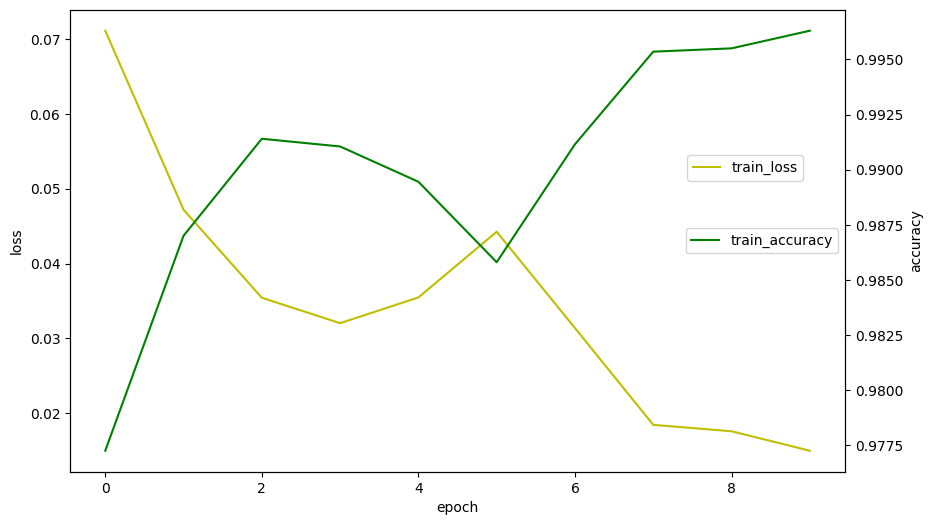

In [28]:
# 5. 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

# 10. 모델 평가

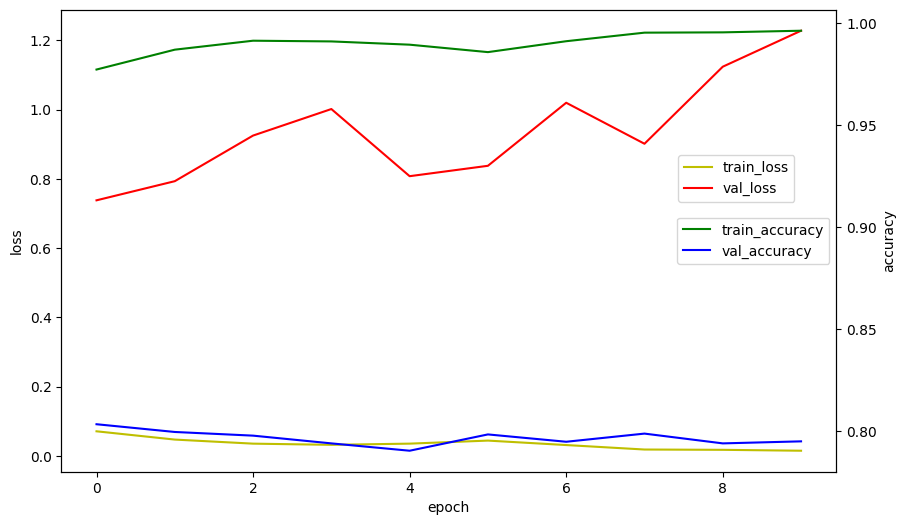

In [29]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [30]:
# 테스트 데이트로 평가
loss,acc = model.evaluate(X_test,y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 7s 8ms/step - loss: 4.4414 - accuracy: 0.4964
test의 데이터 정확도 : 0.49639999866485596
